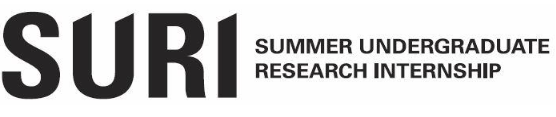

# Interactive Predictive Storage Capacity Calculator

### Carlos Figueroa-Diaz, SURI Researcher, University of Texas at Austin

### The Objective



The purpose of this notebook is to provide a calculator that inputs various production data and outputs predicted CO<sub>2 </sub>  storage capacity. These inputs are the following:

**Pressure** - The reservoir pressure in psia

**CUMO** - Cumulative Oil Production in mmbbl

**CUMG** - Cumulative Gas Production in Bcf

**Water Volume** - initial water volume in mmbbl

**Injection Volume** - volume of injected water in mmbbl

**Depth** - the resevoir depth in ft

**Geothermal Gradient** - the temperature gradient of the reservoir in C/km

**Mean Surface Temperature** - the average surface temperature in C

**API** - the API gravity of the oil

**Efficiency** - the percent storage efficiency 

**GOR** - the gas oil ratio

**Density of CO2** - Density of CO2 in kg/m3

###  Obtaining CO2 Density

The code below approximates the density of CO2 using a given temperature and pressure. Note: This calculator takes in pressures between 0 and 4351 psia and temperatures between 10 and 30 degrees C. 


### The Code
Now that the inputs for this calculator have been defined, let's get into the code. There are sliders for each input. Each slider can be moved to a range of values by the user, to see how changing a certain feature affects predicted storage capacity in real time. These inputs are then used in a function called carbonCalc. 

carbonCalc takes in the inputs from the sliders and through a series of unit conversions and formulas, outputs the predicted storage of CO<sub>2</sub> in kg/m<sup>3</sup>. It calculates the bubble point pressure, formation volume factor for oil, the gas expansion factor, and uses this information to calculate the voided reservoir volume in millions of m<sup>3</sup>. 

The density of CO<sub>2 </sub>, which is approximated using a multivariable regression of a CO2 equation of state, is then multiplied by this reservoir volume to determine the approximate amount of CO<sub>2 </sub> in megatons you could store in the reservoir. Once the inputs are selected, the predicted storage capacity is displayed under the sliders. At any time the user is free to change inputs and observe how a change affects predicted storage capacity. Make sure to run all of the cells below. 

In [3]:
# -*- coding: utf-8 -*-
"""
@author: Carlos Figueroa-Diaz @ The University of Texas at Austin
"""
import numpy as np
import scipy.linalg
import matplotlib.pyplot as plt
from ipywidgets import BoundedFloatText
from matplotlib.widgets import Slider
import math
from IPython.display import display
from scipy.stats import norm
from ipywidgets import interactive                      # widgets and interactivity
from ipywidgets import widgets                            
from ipywidgets import Layout
from ipywidgets import Label
from ipywidgets import VBox, HBox
from scipy.stats import norm    

name = 'Predicted Storage Capacity Calculator, Carlos Figueroa-Diaz,  The University of Texas at Austin'

#Making an author label
l = widgets.Text(value=name.center(200),layout=Layout(width='950px', height='30px'))

#Creating sliders for all of the CO2 params
P = widgets.FloatSlider(min = 1, max = 4351.13, value = 50, step = 1, description = 'Pressure (psia)',orientation='vertical',continuous_update=True,
                          layout=Layout(width='120px', height='300px'))
CUMO = ndata = widgets.FloatSlider(min = 0, max = 1e3, value = 50, step = 1, description = 'CUMO (mmbbl)',orientation='vertical',continuous_update=True,
                          layout=Layout(width='120px', height='300px'))
CUMG = ndata = widgets.FloatSlider(min = 0, max = 1e3, value = 50, step = 1, description = 'CUMG (Bcf)',orientation='vertical',continuous_update=True,
                          layout=Layout(width='120px', height='300px'))
water = ndata = widgets.FloatSlider(min = 0, max = 1e3, value = 50, step = 1, description = 'Water Volume (mmbbl)',orientation='vertical',continuous_update=True,
                          layout=Layout(width='140px', height='300px'))
injection = ndata = widgets.FloatSlider(min = 0, max = 1e3, value = 50, step = 1, description = 'Injection Volume (mmbbl)',orientation='vertical',continuous_update=True,
                          layout=Layout(width='160px', height='300px'))
depth_ft = ndata = widgets.FloatSlider(min = 0, max = 10000, value = 50, step = 1, description = 'Depth (ft)',orientation='vertical',continuous_update=True,
                          layout=Layout(width='120px', height='300px'))
geoGrad = ndata = widgets.FloatSlider(min = 0, max = 100, value = 50, step = 1, description = 'Geothermal Gradient (C/km)',orientation='vertical',continuous_update=True,
                          layout=Layout(width='180px', height='300px'))
meanST = ndata = widgets.FloatSlider(min = 0, max = 100, value = 50, step = 1, description = 'Mean Surface Temp (C)',orientation='vertical',continuous_update=True,
                          layout=Layout(width='140px', height='300px'))
API = ndata = widgets.FloatSlider(min = 0, max = 50, value = 50, step = 1, description = 'API',orientation='vertical',continuous_update=True,
                          layout=Layout(width='120px', height='300px'))
efficiency = ndata = widgets.FloatSlider(min = 0, max = 100, value = 50, step = 1, description = 'Efficiency',orientation='vertical',continuous_update=True,
                          layout=Layout(width='120px', height='300px'))
#initializes the user interface
uipars = widgets.HBox([P,CUMO, CUMG, water,injection, depth_ft, geoGrad, meanST, API, efficiency])
uik = widgets.VBox([l,uipars])

#load first isotherm
files = np.arange(40, 210, 10)
data = np.genfromtxt("C:\\Users\\carlo\\OneDrive\\SURI 2022\\ExxonMobil Project\\Sidequests\\NIST\\30 isotherm.txt",
                     dtype = float, delimiter = '\t', usecols = (0,1,2), skip_header = 1)

#concatenate all isotherm data into T, P, rho array
for i in files:
    isotherm = np.genfromtxt("C:\\Users\\carlo\\OneDrive\\SURI 2022\\ExxonMobil Project\\Sidequests\\NIST\\"
                    + str(i) + " isotherm.txt",  dtype = float, delimiter = '\t', usecols = (0,1,2), skip_header = 1)
    data = np.concatenate((data, isotherm), axis = 0) 

#Code adapted from GitHub users amroamroamro and MSchmidt99
#See more at https://gist.github.com/amroamroamro/1db8d69b4b65e8bc66a6

# regular grid covering the domain of the data
X,Y = np.meshgrid(np.arange(30, 200.5, 0.5), np.arange(10, 30.5, 0.5))
XX = X.flatten()
YY = Y.flatten()

# in: [meshgrid], [meshgrid], [np list of coordinate pair np lists. ex: [[x1,y1,z1], [x2,y2,z2], etc.] ], [degree]
# out: [Z]
def curve(X, Y, coord, n):
    XX = X.flatten()
    YY = Y.flatten()

    # best-fit curve
    A = XYchooseN(coord[:,0], coord[:,1], n)
    C,_,_,_ = scipy.linalg.lstsq(A, coord[:,2])
    # evaluate it on a grid
    Z = np.dot(XYchooseN(XX, YY, n), C).reshape(X.shape)
    return Z

# in: [array], [array], [int]
# out: sum from k=0 to k=n of n choose k for x^n-k * y^k (coefficients ignored)
def XYchooseN(x,y,n):
    XYchooseN = []
    n = n+1
    for j in range(len(x)):
        I = x[j]
        J = y[j]
        matrix = []
        Is = []
        Js = []
        for i in range(0,n):
            Is.append(I**i)
            Js.append(J**i)
            matrix.append(np.concatenate((np.ones(n-i),np.zeros(i))))
        Is = np.array(Is)
        Js = np.array(Js)[np.newaxis]
        IsJs0s = matrix * Is * Js.T
        IsJs = []
        for i in range(0,n):
            IsJs = np.concatenate((IsJs,IsJs0s[i,:n-i]))
        XYchooseN.append(IsJs)
    return np.array(XYchooseN)

Z = curve(X,Y, data, 5)

def findZ(T, P):
    #converting from psia to mPa
    P *= 0.00689476
    pRound = round(P * 2) / 2
    tRound = round(T * 2) / 2
    pIndex = int(2 * pRound - 20)
    tIndex = int(2 * tRound - 60)
    return Z[pIndex][tIndex]

#prints the storage capacity of CO2 based on field data
def carbonCalc(P, CUMG, CUMO, water, injection, depth_ft, geoGrad, meanST, API, efficiency):
    #converts production volumes to m3
    oProd = CUMO * 0.16
    gProd = CUMG *0.0283*1000
    wProd = water * 0.16
    iProd = injection * 0.16
    #preliminary unit conversions and calculations 
    GOR = CUMG / CUMG * 1000
    gasSC = 0.0991
    virginP = P / 145.0
    depth_m = depth_ft * 0.3048
    resT = meanST +  geoGrad * depth_m / 1000.0
    resTR = resT * 9.0/5.0 + 492
    hydroP = depth_m * 10.52 / 1000.0
    oSG = 141.5/ (API + 131)  
    cO = (55.233 * 1e-6) - ((60.588 * 1e-6) * oSG)
    alpha = 0.00091 * (resTR -460) - 0.0125 * API
    #calculates the bubblepoint pressure
    pBub = 18.2 *(((GOR/gasSC)**.83)*(10 ** alpha) -1.4)
    #calculates the formation volume factor for oil and the gas expansion factor
    gasExpFac = 0.101 * (resT + 273) * 1/ (virginP * 273)
    bubFac = 1.0113 + 7.2046e-5 * ((((GOR**0.3738)*((gasSC ** 0.2914) / (oSG ** 0.6265))) + 0.24626 * ((resTR-460)**0.5371)) ** 3.0936)
    volFac = bubFac ** (-cO *(P - pBub))
    #calculates total volume of production
    resVol = oProd *volFac + gProd * gasExpFac + wProd - iProd
    #converts this to megatons of CO2
    rhoCO2 = findZ(resT, P)
    capacity = resVol * (efficiency / 100.0) * rhoCO2 / 1000
    print("Density of CO2 = " + str(round(rhoCO2, 2)) + " kg/m3")
    print("Voided Reservoir Volume = " + str(round(resVol, 2)) +  " million m3")
    print("Storage Capacity = " + str(round(capacity, 2)) + " Megatons of CO2")
    
    
#Plots all of the sliders for the parameters, allowing a user to change parameters in real time
interactive_plot = widgets.interactive_output(carbonCalc, {'P' : P ,'CUMG' : CUMG , 'CUMO' : CUMO, 'water' : water, 'injection' : injection,'depth_ft' : depth_ft
                                                           , 'geoGrad' : geoGrad , 'meanST' : meanST,'API' : API,'efficiency' 
                                                           : efficiency})



### Give it a try!

Run the cell below. Using production data from, change the sliders accordingly. For exact inputs, I recommend double clicking the number slots to type your values instead of using the slider, but it is up to you. As you change inputs, you'll see the predicted storage capacity update in real time.

In [5]:
#displays the plot and user interface
display(uik, interactive_plot)

Output(outputs=({'output_type': 'stream', 'text': 'Density of CO2 = 790.26 kg/m3\nVoided Reservoir Volume = 49…

### References

Thermophysical properties of CO<sub>2 </sub>: https://webbook.nist.gov/cgi/fluid.cgi?ID=C124389&Action=Page

Equations for formation volume factor, bubble point pressure, and oil specific gravity: https://www-sciencedirect-com.ezproxy.lib.utexas.edu/science/article/pii/B9780128002193000048

Oil Compressibility Equation: http://dx.doi.org/10.2118/92-03-02